In [9]:
%load_ext autoreload
%autoreload 
import os

#os.chdir('/home/kathi/Dokumente/ReIn_Course/project/laser-hockey-env-master')
import numpy as np
import laserhockey.hockey_env as h_env
import gym
import torch
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [10]:
def clear_envs():
    for env in env_list:
        env.close()


def add_env(env):
    env_list.append(env)


render = False
solved_reward = 430         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 3000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
n_latent_var = 64           # number of variables in hidden layer
update_timestep = 8000      # update policy every n timesteps (was set to 2000)
lr = 0.0003
betas = (0.9, 0.999)
gamma = 0.99                # discount factor
K_epochs = 80      # update policy for K epochs
eps_clip = 0.2   # clip parameter for PPO
random_seed = 20


import math

import DDPG.PPO_LSTM as PPO 

import DDPG.episodic_memory as EpisodicReplayMemory


env = h_env.HockeyEnv(mode=0)
env_name = 'HockeyEnv'


o_space = env.observation_space
ac_space = env.action_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

use_target = True
action_std = 0.4

ppo = PPO.PPO(o_space.shape[0], ac_space.shape[0] , action_std, n_latent_var, lr, betas, gamma, K_epochs, eps_clip, t_max= 5, device='cpu' )
print("PPO with state dim: {} and action dim {}".format(o_space.shape[0], ac_space.shape[0]))

import matplotlib.pyplot as plt

Box(-1.0, 1.0, (8,), float32)
Box(-inf, inf, (18,), float32)
[(-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf), (-inf, inf)]
PPO with state dim: 18 and action dim 8


In [11]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [12]:
def subplot(fig, R, S, P, Q, path):
    plt.clf()
    r = list(zip(*R))
    s = list(zip(*S))
    p = list(zip(*P))
    q = list(zip(*Q))
    if fig != None:
        plt.close(fig)
    # clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    
    ax[0, 0].plot(list(r[1]), list(r[0]), 'r')  # row=0, col=0
    ax[0, 1].plot(list(s[1]), list(s[0]), 'k')  # row=0, col=1

    ax[1, 0].plot(list(p[1]), list(p[0]), 'b')  # row=1, col=0
    ax[1, 1].plot(list(q[1]), list(q[0]), 'g')  # row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[0, 1].title.set_text('Smoothed Reward')
    ax[1, 0].title.set_text('Loss')
    ax[1, 1].title.set_text('Smoothed Loss')
    plt.pause(0.02)
    fig.savefig(path)
    fig.clear()
    return fig

In [13]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
        self.h_in = []
        self.h_out = []

    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.h_in[:]
        del self.h_out[:]


In [14]:
memory = Memory()

##reading in old ppo:

#ppo.policy_old.load_state_dict(torch.load('results/PPO_HockeyEnv-eps0.2-discount0.99-lr0.0005-random_choice95-time20210306-183529.pth'))

In [15]:
# for hyperparameter tuning:
eps_clips = [0.3, 0.28]   # clip parameter for PPO
lrs = [0.0005, 0.00001]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
update 128
30: Episode reward: -20.061956820794947 
 loss 0.44926536083221436
Best reward 8.301782981783447 at episode 5


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

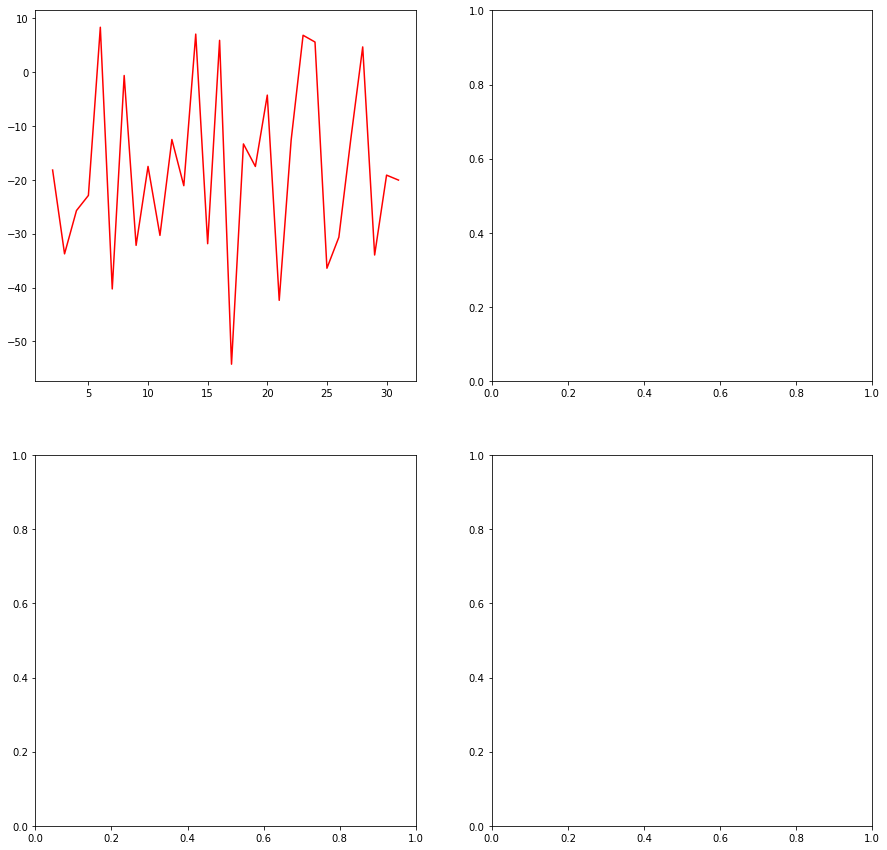

In [17]:
%load_ext autoreload
%autoreload 
import datetime

from pathlib import Path

plot_reward = []
plot_loss = []
plot_smoothed_reward = []
plot_smoothed_losses = []

#replay_number = 5

fps = 50
show = False
stats = []
losses = []
#random_explore_no = 300
total_steps = 0
current_fig = None
best_reward = -np.inf
best_episode = 0
model_dir = "saved_models"


update_timestep = 4000      # update policy every n timesteps (was set to 2000)
#NORMAL = 0
#TRAIN_SHOOTING = 1
#TRAIN_DEFENSE = 2


env = h_env.HockeyEnv(mode=0)
opponent = h_env.BasicOpponent(weak=False)



time_step = 0

plot_reward = []
plot_smoothed_reward = []
plot_loss = []
plot_smoothed_reward = []

eps_clip = 0.2

lr = 0.0005

gamma = 0.99

max_episodes = 800

random_choice_par = 95

loss = 0


memory = Memory()

# training loop
for episode in range(1, max_episodes+1):
    ##initalize hidden states:
    h_out = (torch.zeros([1, 1, 32], dtype=torch.float), torch.zeros([1, 1, 32], dtype=torch.float))

    running_reward = 0
    running_loss = 0
    state = env.reset()
    obs_agent2 = env.obs_agent_two()
    
    for t in range(max_timesteps):
        time_step +=1
        
        # choose random action with certain probability:
        if int(np.random.choice(100)) > random_choice_par:
            action = ppo.random_action()
        
        h_in = h_out
        #else:
        action, h_out = ppo.select_action(state, memory, h_in)
        
        memory.h_in.append(h_in)

        memory.h_out.append(h_out)

        a2 = opponent.act(obs_agent2)

        state, reward, done, info = env.step(np.hstack([action[:4], a2])) 

        obs_agent2 = env.obs_agent_two()
        reward_closeness_to_puck = info['reward_closeness_to_puck']     #it's already included
        reward_puck_direction  = info['reward_puck_direction']
        reward_touch_puck = info['reward_touch_puck']

        reward = reward #+ reward_closeness_to_puck + reward_puck_direction + reward_touch_puck
        # Saving reward and is_terminals:
        memory.rewards.append(reward)
        memory.is_terminals.append(done)

        # update if its time
        if time_step % update_timestep == 0:
            print('update', t)
            ppo.update(memory)
            loss = ppo.loss
            memory.clear_memory()
            time_step = 0
            running_loss += loss
        running_reward += reward

        if render:
            env.render()
        if done:
            break

    stats.append([episode, running_reward])
    losses.append([episode, running_loss])
    try:
        plot_reward.append([running_reward, episode + 1])
        plot_loss.append([running_loss, episode + 1])

        smoothed_rewards = running_mean(np.asarray(stats)[:, 1], 500).tolist()
        smoothed_losses = running_mean(np.asarray(losses)[:, 1], 20).tolist()
        if smoothed_rewards:
            plot_smoothed_reward.append([smoothed_rewards[-1], episode + 1])
        if smoothed_losses:
            plot_smoothed_losses.append([smoothed_losses[-1], episode + 1])

    except:
        continue


    if running_reward > best_reward:

        best_reward = running_reward
        best_episode = episode

    if ((episode > 0) and (episode % 30 == 0)):
        print("{}: Episode reward: {} \n loss {}".format(episode,running_reward, loss))
        print("Best reward {} at episode {}".format(best_reward, best_episode))


        current_fig = subplot(current_fig, plot_reward, plot_smoothed_reward, plot_loss, plot_smoothed_losses, path = f'./figures/PPO_{env_name}-eps{eps_clip}-discount{gamma}-lr{lr}-random_choice{random_choice_par}.jpg')


#plt.savefig(f'./figures/current_fig{env_name}-eps{eps_clip}-discount{gamma}-lr{lr}.png')
time1 = datetime.datetime.now().strftime("%Y%m%d")
time2 = datetime.datetime.now().strftime("%H%M%S")
current_fig = subplot(current_fig, plot_reward, plot_smoothed_reward, plot_loss, plot_smoothed_losses, path = f'./figures/{time1}-{time2}_PPO_{env_name}-eps{eps_clip}-discount{gamma}-lr{lr}-random_choice{random_choice_par}.jpg')

time1 = datetime.datetime.now().strftime("%d")
time2 = datetime.datetime.now().strftime("%H:%M:%S")



path = str('results/' + time1 + '-' + time2)
os.mkdir(path)
torch.save(ppo.policy.state_dict(), f'./{path}/PPO_LSTM_{env_name}-eps{eps_clip}-discount{gamma}-lr{lr}-random_choice{random_choice_par}.pth')


In [9]:
torch.save(ppo.policy.state_dict(), f'./{path}/PPO_{env_name}-eps{eps_clip}-discount{gamma}-lr{lr}-random_choice{random_choice_par}.pth')


In [15]:

opponent = h_env.BasicOpponent(weak=True)
env.render()
time.sleep(1)
obs_agent2 = env.obs_agent_two()
for _ in range(2):
    obs =env.reset()
    obs_agent2 = env.obs_agent_two()
    for _ in range(200):

        time.sleep(0.1)
        env.render()
        a1, _ = ppo.select_action(obs, memory, h_out)
        a2 = opponent.act(obs_agent2)
        obs, r, d, info = env.step(np.hstack([a1[:4], a2]))   
        obs_agent2 = env.obs_agent_two()
        if d: break

In [16]:
env.close()